In [1]:
#import openai gym library
import gym
env = gym.make("CartPole-v1")
observation = env.reset()
import random
random.seed(1)

In [89]:
#simple animation of the cart pole with agent taking random actions (left or right)
for ep in range(1000):
  env.render()
  action = env.action_space.sample() 
  observation, reward, done, info = env.step(action)
  if done:
    observation = env.reset()
env.close()

In [29]:
# documentation of env from gym library
# note the description, the pole has observations (state) described by four features
# and the actions are discrete (either moving left or right)
?env.env

In [30]:
import numpy as np
import gym
env = gym.make("CartPole-v1")
# there are two actions 
print("number of actions: " + np.str(env.action_space.n))
# check the observations bounds for each (position, velocity, angle, angular velocity)
for _ in range(4):
    print (env.observation_space.high[_])
    print (env.observation_space.low[_])

number of actions: 2
4.8
-4.8
3.4028235e+38
-3.4028235e+38
0.41887903
-0.41887903
3.4028235e+38
-3.4028235e+38


In [26]:
# defining the class of Temporal difference (QL and SARSA) agent
import gym
import numpy as np
import math
class TDAgent():
    # buckets show the discretization levels of the four features (position, velocity, angle, angular velocity)
    def __init__(self, buckets=(3, 3, 12, 12), num_episodes=5000, lr=0.8, initial_epsilon=0.9, discount=0.999):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.learning_rate = lr
        self.epsilon = initial_epsilon
        self.discount = discount
        self.env = gym.make('CartPole-v0')
        self.epsilon_min = 0.05
        self.lr_min = 0.1
        # [position, velocity, angle(theta), angular velocity]
        # note that the bounds of velocity and angular velocity are modified manually from infinity (- infinity)
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        # create state-action Q table for the aciton values (Q)
        # this is where the value of each state-action pair is stored
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))

    def discretize_state(self, obs):
        discretized = list()
        for i in range(len(obs)):
            scaling = (obs[i] + abs(self.lower_bounds[i])) / (self.upper_bounds[i] - self.lower_bounds[i])
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)
    
    # in general, starting from high exploration (high epsilon) and high learning rate 
    # we decrease the exploration probability and the learning rate as the training goes on
    
    def getEpsilon(self):
        if (self.epsilon <= self.epsilon_min):
            self.epsilon = self.epsilon_min
        else:
            self.epsilon*=0.9
            
    def getLR(self):
        if (self.learning_rate <= self.lr_min):
            self.learning_rate = self.lr_min
        else:
            self.learning_rate*=0.9
            
    # epsilon - greedy policy to choose action
    def choose_action(self, state):
        # the agent here: it chooses random action for epsilon probability otherwise it exploits
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])
    
    # updating the Q-value table following Qlearning and SARSA algorithms
    def QLupdate(self, state, action, reward, new_state):
        # updating the Q-value of the visited state-action pair
        self.Q_table[state][action] += self.learning_rate * (reward + self.discount * np.max(self.Q_table[new_state]) - self.Q_table[state][action])
    def SARSAupdate(self, state, action, reward, new_state, next_action):
        # updating the Q-value of the visited state-action pair
        self.Q_table[state][action] += self.learning_rate * (reward + self.discount * self.Q_table[new_state][next_action] - self.Q_table[state][action])
    
    # training the Ql agent 
    def QLtrain(self):
        cum_reward = np.zeros((self.num_episodes))
        for ep in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())
            done = False
            while not done:
                #choosing action according to our exploration-exploitation policy
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                cum_reward[ep]+=reward
                new_state = self.discretize_state(obs)
                self.QLupdate(current_state, action, reward, new_state)
                current_state = new_state
            self.getEpsilon()
            self.getLR()
        return cum_reward
        print('QL based training is finished!')
    
    def SARSAtrain(self):
        cum_reward = np.zeros((self.num_episodes))
        for ep in range(self.num_episodes):
            current_state = self.discretize_state(self.env.reset())
            action = self.choose_action(current_state)
            done = False
            while not done:
                #choosing action according to our exploration-exploitation policy
                obs, reward, done, _ = self.env.step(action)
                cum_reward[ep]+=reward
                new_state = self.discretize_state(obs)
                next_action = self.choose_action(new_state)
                self.SARSAupdate(current_state, action, reward, new_state, next_action)
                current_state = new_state
                action = next_action
            self.getEpsilon()
            self.getLR()
        return cum_reward
        print('SARSA based training is finished!')


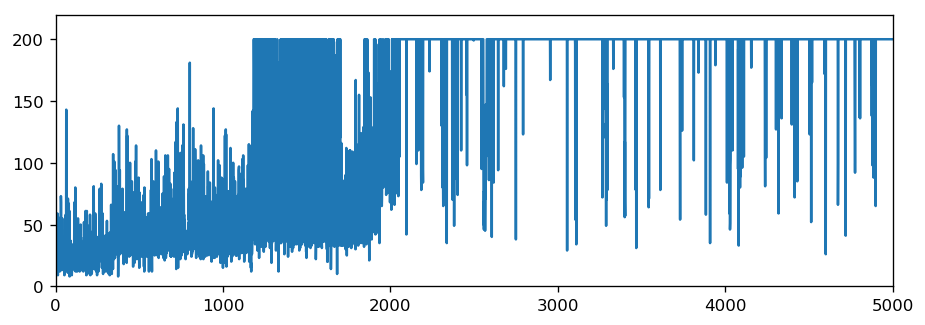

In [27]:
if __name__ == "__main__":
    QLagent = TDAgent()
    cum_reward = QLagent.QLtrain()
    #t = agent.run()
    #print("Time", t)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(9, 3), dpi=120, facecolor='w', edgecolor='k')
plt.plot(cum_reward)
axes = plt.gca()
axes.set_xlim([0,5000])
axes.set_ylim([0,220])
plt.show()

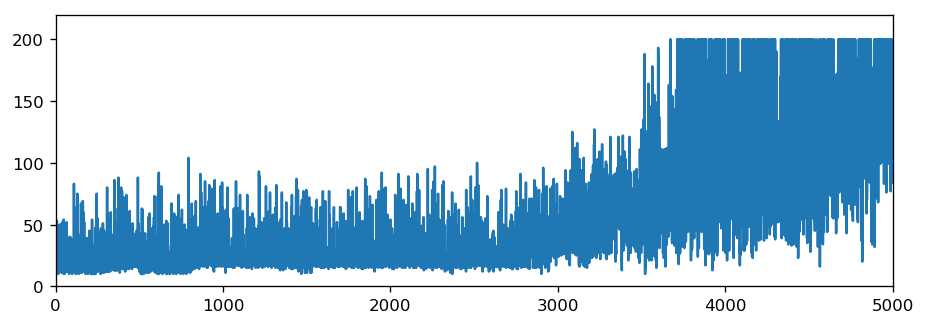

In [28]:
if __name__ == "__main__":
    SARSAagent = TDAgent()
    cum_reward = SARSAagent.SARSAtrain()
    #t = agent.run()
    #print("Time", t)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(9, 3), dpi=120, facecolor='w', edgecolor='k')
plt.plot(cum_reward)
axes = plt.gca()
axes.set_xlim([0,5000])
axes.set_ylim([0,220])
plt.show()